#  Optimal split of orders across liquidity pools (Regular Market and Dark Pools)

In this notebook, we tackle the problem of optimally splitting orders across dark pools to maximize trading efficiency and minimize market impact. Dark pools, being private exchanges where large orders can be executed away from the public eye, offer unique advantages such as reduced price slippage and lower market impact. However, efficiently allocating orders across multiple dark pools is a complex task, requiring careful consideration of factors such as liquidity, execution costs, and timing

- Dark Pool Definition : 

A dark pool offers a bid price for an Over-The-Counter (OTC) transaction, with no guarantee on the quantity that will be executed. This bid price is usually lower than the one available on the regular market.

The influence of having $N$ dark pools on a particular transaction can be modeled as follows:


- $V > 0$ represents the random volume to be executed.
- $\theta_i \in (0, 1)$ be the discount factor offered by dark pool $i$.
- $r_i$ denote the proportion of $V$ allocated to dark pool $i$ for execution.
- $D_i \geq0$ represents the quantity of securities that can be provided by dark pool $i$ at the discounted price $\theta_i S$.



The reminder of the order that didn't manage to be executed on the dark pool will be executed on the regular market at price $S$

# Cost of the executed Order : 

The cost of the executed order can be written as :

$$C = S\sum_{i=1}^N \theta_i min(r_iV, D_i) + S\left( V- \sum_{i=1}^N min(r_iV, D_i)\right)$$

$$C = S\left(V - \sum_{i=1}^N \rho_i min(r_iV,D_i) \right)$$

Where: $$\rho_i := 1-\theta_i \in (0,1)$$

# Problem Set up : 

We want to minimze $\mathbb{C}$ and therefore maximize the following quantity :

$$\max {\left[ \sum_{i=1}^N \rho_i \mathbb{E}(min(r_iV,D_i)) \right] , r\in\mathcal{P}_N}$$

where : $$\mathcal{P}_N = \left( r=(r_i)_{1\leq i \leq N} \in \mathbb{R}^N_+ \mid \sum_{i=1}^N =1  \right)$$

# Problem Resolution

We set for every $r = (r_1, ..., r_N) \in \mathcal{P}_N$

$$\Phi (r) = \sum_{i=1}^N \phi_i(r_i)$$

where for every $i\in I_N = {1, ..., N}$:

$$\phi_i(u) = \rho_i \mathbb{E} \left[ \min(uV, D_i) \right ] $$

We aim at solving the following maximization problem :

$$\max_{r\in\mathcal{P}_N} \Phi(r)$$

Using the Lagrangian approach, we define :

$$L(r,\lambda) = \Phi(r) - \lambda \left (\sum_{i=1}^N r_i -1 \right ) $$

The first order equilibrium solutions give :

$$\forall i \in I_N, \frac{\partial L}{\partial r_i} = \phi '_i (r_i) - \lambda$$

This suggests that any $r^*\in \argmax_{\mathcal{P}_N} \Phi$ if and only if $\phi'_i(r_i^*)$ is constant when $i$ runs over $I_N$ or equivalently if:

$$\forall i \in I_N : \phi '_i(r_i^*) = \frac{1}{N} \sum_{j=1}^N \phi '_j(r_j^*)$$

Then using that : 

$$\forall i\in I_N, \phi'_i(r) = \rho_i\mathbb{E}\left(\mathbb{I}_{r_iV<D_i}V \right)$$

we find :

$$r^* \in \argmax_{\mathcal{P}_N} \Phi$$

$$\Leftrightarrow \forall i \in I_N, \quad \mathbb{E} \left[ V\left(   \rho_i\mathbb{I}_{r_i^*V<D_i}   - \frac{1}{N} \sum_{j=1}^N \rho_j\mathbb{I}_{r_j^*V<D_j}         \right )\right]$$

Which leads to the following recursive zero search procedure :

$$r_i^{n+1} = r_i^n + \gamma_{n+1} H_i(r^n, Y^{n+1}), \quad r^0\in\mathcal{P}_N, i\in I_N$$

where for $i\in I_N$, every $r\in\mathcal{P}_N$, every $V>0$ and every $D_1, ... D_N \geq 0 $, 

$$H_i(r, Y)= V\left(   \rho_i\mathbb{I}_{r_i^*V<D_i}   - \frac{1}{N} \sum_{j=1}^N \rho_j\mathbb{I}_{r_j^*V<D_j}         \right )$$

Remark : 

The core idea of the algorithm is to incentivize dark pools that outperform the average of the $N$  dark pools by increasing the volume allocated to them in the next step, and to decrease it for those that underperform.


# Python Implementation : 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We solve the problem on 15 days

In [2]:
init_date = '2011-07-01'
end_date = '2011-07-31'

In [6]:
# Regular market
df_lvmh  = pd.read_hdf("./LVMH.h5")    
df_lvmh = df_lvmh[(df_lvmh.index >= pd.Timestamp(init_date)) & (df_lvmh.index <= pd.Timestamp(end_date))]

# 3 Darkpools
df_bouygues  = pd.read_hdf("./BOUYGUES.h5")
df_bouygues = df_bouygues[(df_bouygues.index >= pd.Timestamp(init_date)) & (df_bouygues.index <= pd.Timestamp(end_date))]

df_sanofi  = pd.read_hdf("./SANOFI.h5")
df_sanofi = df_sanofi[(df_sanofi.index >= pd.Timestamp(init_date)) & (df_sanofi.index <= pd.Timestamp(end_date))]

df_total  = pd.read_hdf("./TOTAL.h5")
df_total = df_total[(df_total.index >= pd.Timestamp(init_date)) & (df_total.index <= pd.Timestamp(end_date))]

- LVMH represents the regular market

- Bouygues, Sanofi et Total represent the $3$ darkpools

The stochastic gradient descent will occur every 5 minutes:

In [7]:
T = pd.Timedelta(minutes=5)

In [8]:
df_lvmh.head(5)

,TradedPrice,TradedQty,BidPrice,AskPrice,BidQty,AskQty,TradedSign
Time,,,,,,,
2011-07-01 09:00:01.149,123.0,6,122.8,123.0,600000,100000,1
2011-07-01 09:00:01.149,123.0,48,122.8,123.0,600000,100000,1
2011-07-01 09:00:01.149,123.0,12,122.8,123.0,600000,100000,1
2011-07-01 09:00:01.149,123.0,10,122.8,123.0,600000,100000,1
2011-07-01 09:00:01.149,123.0,1,122.8,123.0,600000,100000,1


We start by implementing dark pools model :

The capacity for $i=1,2,3$ are :

$D_i =  \beta_i [ (1-\alpha_i) V + \alpha_i S_i \frac{\mathbb{E}(V)}{\mathbb{E}(S_i)} ]$

With :

- $D_i$ : the capacity of darkpool i.

- $alpha_i \in (0,1)$ the recombination coefficients of the dark pools.

- $\beta_i$ scaling factors

- $\mathbb{E}V$ et $\mathbb{E}S_i$ the empirical means of the LVMH datasets and the dark pools.

In [3]:
# Parameters used for the darkpools
beta_bouygues = 0.1
beta_sanofi = 0.2
beta_total = 0.2
betas = [beta_bouygues, beta_sanofi, beta_total]

alpha_bouygues = 0.4
alpha_sanofi = 0.6
alpha_total = 0.8
alphas = [alpha_bouygues, alpha_sanofi, alpha_total]

rho_bouygues = 0.01
rho_sanofi = 0.02
rho_total= 0.04
rhos = [rho_bouygues, rho_sanofi, rho_total]

In [11]:
# Computations of E(V) and of E(S_i)

mean_V = df_lvmh['BidQty'].resample(T).last().dropna().mean() #E(V)
mean_S_bouygues = df_bouygues['BidPrice'].resample(T).last().dropna().mean() #E(S_1)
mean_S_sanofi = df_sanofi['BidPrice'].resample(T).last().dropna().mean() #E(S_2)
mean_S_total = df_total['BidPrice'].resample(T).last().dropna().mean() #E(S_3)

We then deduce the capacities \( D_i \) every 5 minutes:

In [16]:
Volume_lvmh = df_lvmh['BidQty'].resample(T).last().dropna()
Price_lvmh = df_lvmh['BidPrice'].resample(T).last().dropna()

D_bouygues = beta_bouygues * ((1-alpha_bouygues)*df_lvmh['BidQty'].resample(T).last() 
                             + alpha_bouygues*df_bouygues['BidPrice'].resample(T).last() * mean_V/mean_S_bouygues)

D_bouygues.loc['2011-07-08 13:45:00'] = 0 ### ATTENTION, sur la plage de temps 13:45:00, il n'y a pas de données pour Bouygues.
# Enfaite, il y a un NaN signifiant qu'il n'y a pas de BidQty pour Bouygues. On remplace ce NaN par 0.
D_bouygues = D_bouygues.sort_index() # On retrie la ligne 13:45:00 pour l'insérer à la bonne place.


D_sanofi = beta_sanofi * ((1-alpha_sanofi)*df_lvmh['BidQty'].resample(T).last()
                        + alpha_sanofi*df_sanofi['BidPrice'].resample(T).last() * mean_V/mean_S_sanofi)

D_total = beta_total * ((1-alpha_total)*df_lvmh['BidQty'].resample(T).last()
                        + alpha_total*df_total['BidPrice'].resample(T).last() * mean_V/mean_S_total)

D_bouygues = D_bouygues.dropna()
D_sanofi = D_sanofi.dropna()
D_total = D_total.dropna()

D = pd.concat([D_bouygues, D_sanofi, D_total], axis=1)
D = D.fillna(0)
D = np.array(D.T)


In [17]:
D

array([[ 3199.56574899,  5032.80914811,  8650.45789202, ...,
         3214.88355254,  3911.91059689, 14725.8024195 ],
       [ 8755.76770195, 11184.64346574, 16020.9510011 , ...,
         9219.91026913, 10138.5375605 , 24537.54367083],
       [11719.70719683, 12940.10075158, 15352.49430633, ...,
        11476.59032758, 11927.40966333, 19102.79670708]])

In [18]:
D.shape

(3, 2142)

- Oracle Algorithm : We introduce an Omnicient Agent that is able to know the "perfect" trade to do at every date. This means he knows the exact capacity of each darkpool during the all simulation. We will compare our algorithm to the Oracle.

$D$ contains the capacities $D_i^k$, $i=1,2,3$, of the dark pools.

We will implement two algorithms to determine $r = (r_1, r_2, r_3)$, the percentages of $V$ to allocate to the different pools:


- For the stochastic algorithm, at each time step $k$, we use the composition $r^{k-1}$ to place an order of volume $V$. The composition $r^{k-1}$ is updated according to the new capacities of the dark pools at time $k$.

- For the oracle algorithm, at each time step $k$, we calculate the best composition $r^k$ to place an order of volume $V$. Unlike the stochastic case, the oracle knows the new capacities of the dark pools at time $k$ and therefore does not suffer from information constraints.



The goal is to compare the "optimal" compositions found by the stochastic algorithm during gradient descent with the truly optimal compositions of the oracle.


### Stochastic Algorithm :

Certain comments in the code allow for resetting the composition $r_i$ daily, as shown in the slides.

Given that no regime changes are observed on the selected dates, there is no benefit to resetting the $r_i$.


Additionally, in the comments, it is possible to activate a decreasing learning rate of $\frac{10}{n \cdot \ln(n)^3}$, which was found purely empirically. In practice, the compositions $r_i$ are quite noisy, as we will see below, so we do not consider this to be a critically important parameter.


Finally, we need to "clip" the compositions $r_i$ to the interval $(0,1)$. Indeed, if we do not enforce normalization and confine the compositions $r_i$ within $(0,1)$, gradient descent will drive them outside this range.


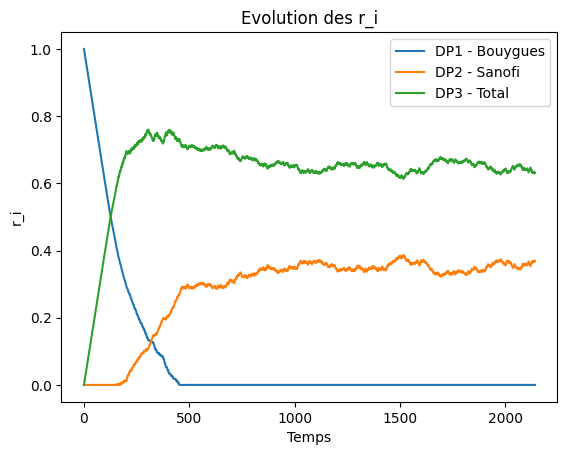

In [27]:
import warnings
warnings.filterwarnings("ignore")

r_list = []

# Starting Point
r0 = np.array([1, 0.0, 0.0]) 
r_list.append(r0)

N = 3
V = 20000
learning_rate = 0.00001


#learning_rate_decay = [10/(k*np.log(k)**3) for k in range(2, len(D.T)+1)]
#print(learning_rate_decay)

# H list of the gradient descent
H_list = []

# Cost list of the composition r_i^k which is affected by the darkpool following at time k+1
cost_sto = []

for i in range (len(D.T)-1):

    #if i % 102 != 0: 
    r_current = np.clip(r_list[-1], 0, 1)
    r_current = np.array(r_current)/np.sum(r_current)
    #else: r_current = np.array([0.8, 0.1, 0.1]) #reset

    # the actual r is affected by the dark pools following at time k+1

    cost = Price_lvmh[i]* (V - np.sum(rhos[j] * min(r_current[j]*V, int(D[j,i])) for j in range(N)))
    cost_sto.append(cost)
    #r_current = r_list[-1]
        
    H_bouygues = V * (rho_bouygues * (r_current[0]*V < D_bouygues[i]) - 
                      (1/N) * np.sum([rhos[k]*(r_current[k]*V < D[:,i][k]) for k in range(len(rhos))]))
    
    H_sanofi = V * (rho_sanofi * (r_current[1]*V < D_sanofi[i]) -
                    (1/N) * np.sum([rhos[k]*(r_current[k]*V < D[:,i][k]) for k in range(len(rhos))]))
    
    H_total = V * (rho_total * (r_current[2]*V < D_total[i]) -
                     (1/N) * np.sum([rhos[k]*(r_current[k]*V < D[:,i][k]) for k in range(len(rhos))]))
    
    #r_new = r_current + learning_rate_decay[i] * np.array([H_bouygues, H_sanofi, H_total])
    r_new = r_current + learning_rate * np.array([H_bouygues, H_sanofi, H_total])
    H_list.append([H_bouygues, H_sanofi, H_total])
    #r_list.append(r_new)
    r_new = np.clip(r_new, 0, 1)
    r_new = r_new/np.sum(r_new)
    r_list.append(r_new)

    
r_list = np.array(r_list[:-1])

plt.plot(r_list, label = ['DP1 - Bouygues', 'DP2 - Sanofi', 'DP3 - Total'])
plt.title("Evolution des r_i")
plt.xlabel("Temps")
plt.ylabel("r_i")
plt.legend()
plt.show()

`Remark: `We can observe that the compositions $r_i$ converge (though with some noise). Additionally, they converge in decreasing order of $\rho_i$, which makes sense since a larger $\rho_i$ indicates that dark pool $i$ offers a greater discount.

Indeed, we had $\rho_{\text{total}} > \rho_{\text{sanofi}} > \rho_{\text{bouygues}}$.


### Oracle Algorithm : 

Here, we know in advance the capacities of the dark pools, so we can determine the optimal composition to purchase a volume $V$.

Specifically, we buy the maximum number of LVMH shares from the dark pool with the highest $\rho_i$, then we buy the maximum number of LVMH shares from the dark pool with the second highest $\rho_i$, and so on, until we have purchased $V$ shares. If $V$ exceeds the total sum of the capacities of the dark pools, we purchase the remaining shares on the regular market.


This gives : 

In [28]:
# oracle
r_oracle = []
cost_oracle = []

for k in range (len(D.T)-1):


    remaining_volume = V
    DP_volumes = D[:, k][::-1]
    sorted_rhos = rhos[::-1]
    executed_quantity = [0, 0, 0]

    
    for i in range(len(DP_volumes)):
        if DP_volumes[i] < remaining_volume:
            executed_quantity[i] = DP_volumes[i]
            remaining_volume -= DP_volumes[i]
        else:
            executed_quantity[i] = remaining_volume
            remaining_volume = 0

    #print(DP_volumes, executed_quantity)

    r = np.array(executed_quantity)/V
    #print(r, remaining_quantity, executed_quantity)
    #print(r, sorted_rhos)
    r_oracle.append(r)
    #print(remaining_quantity, executed_quantity, r, remaining_volume)
   

    cost = Price_lvmh[k] * (V - np.sum([sorted_rhos[j] * min(executed_quantity[j], DP_volumes[j]) for j in range(len(rhos))]))
    cost_oracle.append(cost)

We verify that the cost of purchasing the volume $V$ using the composition from the oracle is always better than that obtained from the stochastic algorithm.


In [32]:
for k in range(len(cost_oracle)):
    if cost_oracle[k] > cost_sto[k]:
        print(k, cost_oracle[k], cost_sto[k])

Let's now display the costs of the two algorithms:


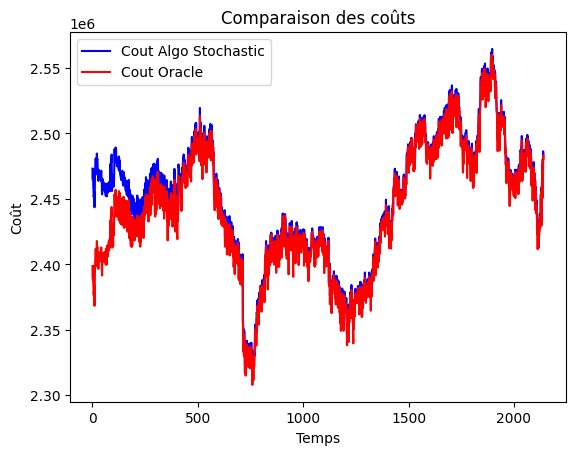

In [31]:
plt.plot(cost_sto, color='blue', label='Cout Algo Stochastic')
plt.plot(cost_oracle, color='red', label= 'Cout Oracle')
plt.title("Comparaison des coûts")
plt.xlabel("Temps")
plt.ylabel("Coût")
plt.legend()
plt.show()


In fact, we plot the relative performance, which is the relative deviation between the costs of the stochastic algorithm and the optimal costs of the oracle (reference = 100).


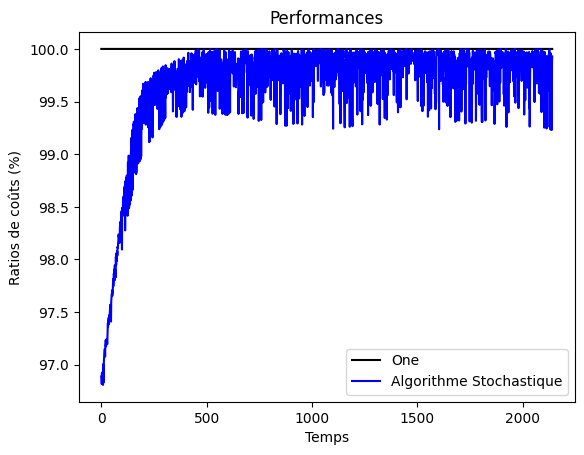

In [38]:
cost_ref = [100 for k in range(len(cost_oracle))]
relative_cost = 100-((np.array(cost_sto)/np.array(cost_oracle))*100 - 100)

plt.plot(cost_ref, color='black', label='One')
plt.plot(range(len(relative_cost)), relative_cost, color='blue', label='Algorithme Stochastique')
plt.xlabel("Temps")
plt.ylabel("Ratios de coûts (%)")
plt.title("Performances")
plt.legend()
plt.show()


`Remark`: One day equals 102 time units of 5 minutes each. Indeed, 1 day $= 17\text{h}30 - 9\text{h} = 8\text{h}30 = 510$ minutes $= 102 \times 5$ minutes.


The stochastic algorithm succeeds in finding a very good purchase composition across the dark pools. However, some noise is still noticeable.


`Remarque` In principle, we do not need to perform a daily reset of the $r_i$ in the stochastic algorithm, as it functions correctly.

To test this, simply go back to the cell above and remove the comments on the line #if $i=102 \rightarrow$ reset current $r$ to $r_0$} and then rerun the calculations.


# Conclusion :

In this notebook, we addressed the problem of optimally splitting orders across dark pools and the regular market using a stochastic algorithm. We compared the performance of this algorithm to an omniscient agent that knows in advance the capacities of the dark pool at the next date. Overall, the stochastic algorithm achieve an efficient split of orders accross the different liquidity pools.